In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualizing Decision borders on 2D Hyperplanes
The title says it.
First we prepare the experiments
1. Get data and visualize it
2. Define, train and load models
3. Do PCA and the standard PCA visualizations
Then we can do the basic of the experiment, and visualize the decision border along the hyperplane in that the data has the maximum variance, defined by mean + a*PC1 + b*PC2
4. Hyperplane projection and Decision Border visualization
Now we can play around
5. Decision border during training
6. Decision border of a network trained to overfit random labels
7. Adversarial Examples: we can try to explain adversarial examples by showing the decision border in a hyperplane that contains the adversarial noise.
8. Gradient of two class problem as vectorfield in hyperplane

## Data
- Get trained and untrained models
- Load data
- visualize stuff

In [103]:
na = None

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train -= X_train.min()
X_train = X_train / X_train.max()
X_train = 2*X_train - 1

X_test -= X_test.min()
X_test = X_test / X_test.max()
X_test = 2*X_test - 1

Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

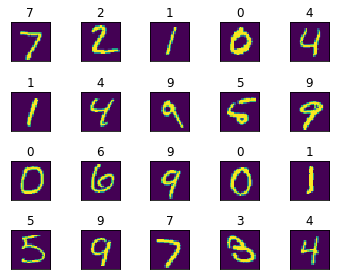

In [89]:

def visualize_digits(X, Y=None):
    X = (X+1)/2
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(cols,rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            y = Y[i]
            ax.set_title(np.argmax(y))
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        ax.imshow(x)
    plt.tight_layout()
    plt.show()
    
visualize_digits(X_test[:20], Y_test[:20])


# Models and Training

In [85]:
def get_cnn():
    model = Sequential()
    target_shape = X_train.shape[1:] if len(X_train.shape)==4 else list(X_train.shape)[1:] + [1]
    print(target_shape)
    model.add(keras.layers.Reshape(target_shape, input_shape=X_train.shape[1:]))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    model.add(Dense(Y_train.shape[1]))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.Adam()

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
              
    return model


              
def get_trained_cnn():
    cnn = get_cnn()
    try:
        cnn.load_weights("cnn.hdf5")
    except Exception as e:
        print("Loading failed: ", type(e), e)
        cnn.fit(X_train, Y_train,
              batch_size=5,
              validation_split=1/6,
              epochs=4)
        cnn.save("cnn.hdf5")
    acc = cnn.evaluate(X_test, Y_test)
    print(acc)
    return cnn


cnn = get_trained_cnn()

    

[28, 28, 1]
Loading failed:  <class 'ValueError'> You are trying to load a weight file containing 1 layers into a model with 4 layers.
Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 239s 5ms/step - loss: 0.1438 - acc: 0.9558 - val_loss: 0.0525 - val_acc: 0.9865
Epoch 2/4
50000/50000 [==============================] - 236s 5ms/step - loss: 0.0702 - acc: 0.9788 - val_loss: 0.0516 - val_acc: 0.9848
Epoch 3/4
50000/50000 [==============================] - 236s 5ms/step - loss: 0.0588 - acc: 0.9822 - val_loss: 0.0427 - val_acc: 0.9899
Epoch 4/4
10000/10000 [==============================] - 4s 420us/step
[0.04314304168792441, 0.9881]


In [128]:
def get_linear():
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(Y_train.shape[1]))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.Adam()

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
              
    return model


def get_trained_linear():
    model = get_linear()
    try:
        model.load_weights("linear.hdf5")
    except Exception as e:
        print("Loading failed: ", type(e), e)
        model.fit(X_train, Y_train,
              batch_size=5,
              validation_split=1/6,
              epochs=4)
        model.save("model.hdf5")
    acc = model.evaluate(X_test, Y_test)
    print(acc)
    return model

linear = get_trained_linear()

Loading failed:  <class 'OSError'> Unable to open file (unable to open file: name = 'linear.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 28s 564us/step - loss: 0.4462 - acc: 0.8661 - val_loss: 0.3220 - val_acc: 0.9098
Epoch 2/4
50000/50000 [==============================] - 31s 614us/step - loss: 0.3834 - acc: 0.8934 - val_loss: 0.4231 - val_acc: 0.8762
Epoch 3/4
50000/50000 [==============================] - 24s 479us/step - loss: 0.3695 - acc: 0.8961 - val_loss: 0.3932 - val_acc: 0.8939
Epoch 4/4
10000/10000 [==============================] - 0s 44us/step
[0.32220052661821247, 0.9152]


# PCA
1. Prepare data (flatten)
2. Do PCA
3. Show eigenvectors and mean
4. Show decreasing eigenvalues
5. 

In [109]:
X = X_test.reshape([-1, 784])
print(X_test.shape, X.shape)
Y = Y_test

(10000, 28, 28) (10000, 784)


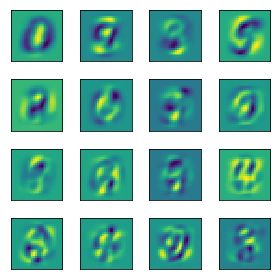

In [142]:
X_mean = np.mean(X, axis=0, keepdims=True)
#X = X - X_mean

#visualize_plt(X_mean)

u, s, v = np.linalg.svd(X-X_mean, full_matrices=False)
visualize_digits(v[:16])

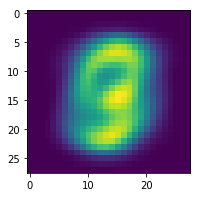

In [143]:

plt.figure(figsize=(3,3,))
plt.imshow(X_mean[0].reshape(28,28))
plt.show()

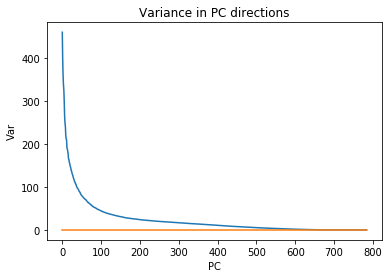

In [100]:
plt.clf()
plt.plot(range(784), s)
plt.plot([0,784], [0,0])
plt.xlabel("PC")
plt.ylabel("Var")
plt.title("Variance in PC directions")
plt.show()


# Hyperplane Projections
A hyperplane can be defined as X_0 + alpha*V_0 + beta*V_1
Let's write a method to project onto that hyperplane, and to project back into the high dimensional space.
If X_0 is the mean of the data, and V_0, V_1 are PCs, this is the projection with the maximum variance ("largest shadow").
We can sample a grid on the hyperplane and visualize the decision border in that hyperplane.

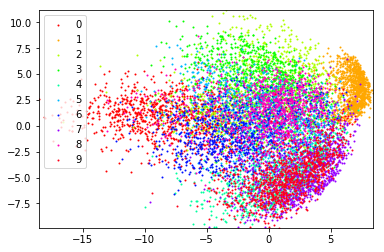

<Figure size 432x288 with 0 Axes>

In [179]:
class Plane():
    def __init__(self, X0, V):
        # V: (d, D)
        self.d = V.shape[0]
        assert np.allclose(V.dot(V.T),np.eye(self.d)), "Directions must be orthogonal, change V"
        self.X0, self.V = X0, V
    
    def to_plane(self, X):
        return (X - self.X0).dot(self.V.T)
        pass
    
    def from_plane(self, G):
        return G.dot(self.V) + self.X0
    
    def grid_around(self, X, shuffle=False, R=100):
        X_w = self.to_plane(X)

        x_min, x_max = np.min(X_w[:,0]), np.max(X_w[:,0])
        y_min, y_max = np.min(X_w[:,1]), np.max(X_w[:,1])
        scale = np.diag([(x_max-x_min), (y_max-y_min)])
        bias = np.array([x_min, y_min])
        grid = np.indices([R, R]).T.reshape(R*R, -1)/(R-1)
        #for x in Grid_w
        grid = grid.dot(scale) + bias
        X_g = plane.from_plane(grid)

        grid_limits = np.array([grid[:,0].min(), grid[:,0].max(), grid[:,1].min(), grid[:,1].max()])
        true_limits = np.array([x_min,x_max, y_min, y_max])

        if shuffle:
            perm = np.random.permutation(X_g.shape[0])
            X_g, grid = X_g[perm], grid[perm]
        return X_g
    
    @staticmethod
    def from_pca(PCs):
        return Plane(X_mean, v[PCs])

plane = Plane.from_pca([0,1])

c = plt.cm.get_cmap("hsv", 10)
colors = [c(i) for i in range(10)]

# pc plot with colors for labels
def plot_classes(X, Y, plane, labels=range(10), s=1, show_legend=True, **kwargs):
    # X_pca: shape (N, d), decorrelated
    X = plane.to_plane(X)
    existing_classes=[]
    for label in labels:
        y = np.argmax(Y, axis=1)
        X_l = X[y==label]
        if X_l.shape[0] == 0:
            continue
        existing_classes.append(label)
        if show_legend:
            plt.scatter(X_l[:,0], X_l[:,1], color=colors[label], label=label, s=s, **kwargs)
        else:
            plt.scatter(X_l[:,0], X_l[:,1], color=colors[label], s=s, **kwargs)
        if show_legend:
            plt.legend()
    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    return existing_classes

plot_classes(X, Y, plane)
plt.show()
plt.clf()

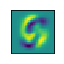

In [170]:
# create a grid, recreate images from assuming the grid is the position in the whitened field
# and plot the classification of these images


test = plane.from_plane(np.array([[1,-1]]))

visualize_digits(test)


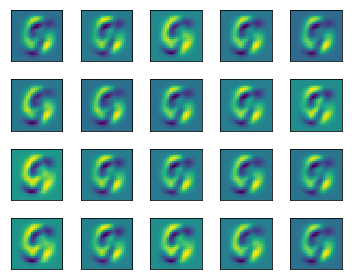

In [180]:
X_g = plane.grid_around(X, shuffle=True)
visualize_digits(X_g[:20]+X_mean)

In [185]:
def show_decision_grid1(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(6,6))
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.6, show_legend=False)
    plot_classes(X, Y, plane, labels=labels, s=2)
    plt.show()

def show_decision_grid2(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.6)
    plt.subplot(1,2,2)
    plot_classes(X, Y, plane, labels=labels, s=2)
    plt.show()

def show_decision_grid3(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(6,6))
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.6, show_legend=False)
    plt.show()
    



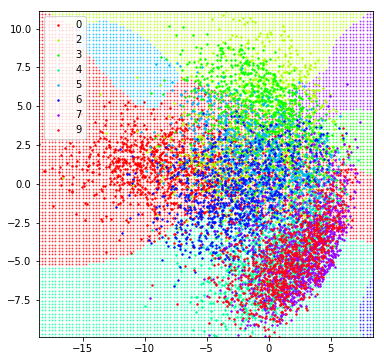

<Figure size 432x288 with 0 Axes>

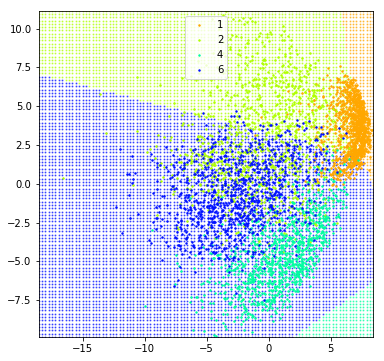

<Figure size 432x288 with 0 Axes>

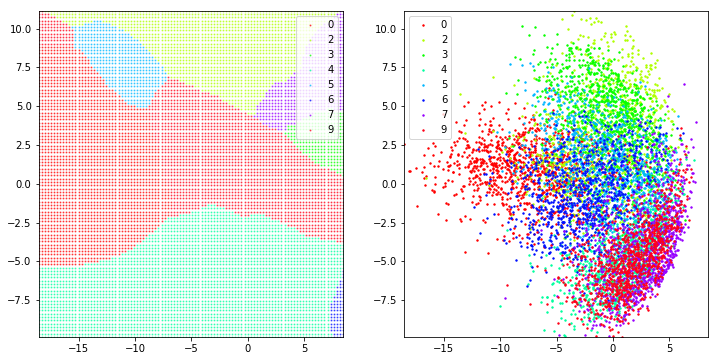

<Figure size 432x288 with 0 Axes>

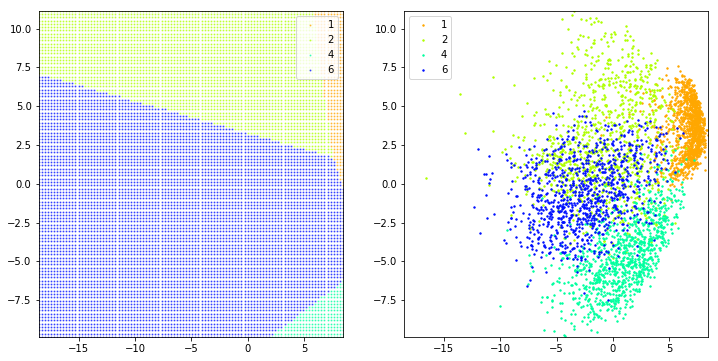

<Figure size 432x288 with 0 Axes>

In [186]:
show_decision_grid1(plane)
plt.clf()
show_decision_grid1(plane, linear)
plt.clf()
show_decision_grid2(plane)
plt.clf()
show_decision_grid2(plane, linear)
plt.clf()

limit error:  [0.00000000e+00 1.77635684e-15 0.00000000e+00 0.00000000e+00]


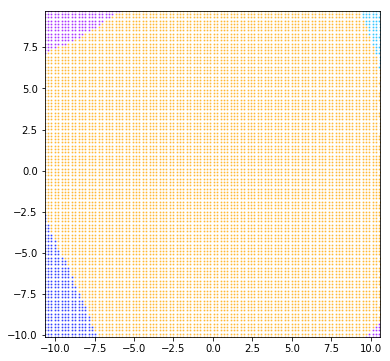

In [141]:
show_decision_grid3([2,4], cnn)

# Move along another axis


# Visualize Training
We now want to visualize, how the decision borders in the hyperplane of the first two PCs changes during training.
1. Define new networks
2. Write method to train them on batches and visualize the decision border after each time

In [19]:
fcn1 = Network([Format(), FirstLinear(784), ReLU(), NextLinear(10)],
                  data.X, data.y_)
fcn2 = Network([Format(), FirstLinear(784), ReLU(), FirstLinear(784), ReLU(),
                FirstLinear(784), ReLU(), NextLinear(10)],
                  data.X, data.y_)


fcn1.set_session(sess)

sess.run(tf.global_variables_initializer())


Network layer mappings: (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 10)
Network layer mappings: (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 10)
Network layer mappings: (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 10)


Train step  0 :  0.1464
limit error:  [0. 0. 0. 0.]


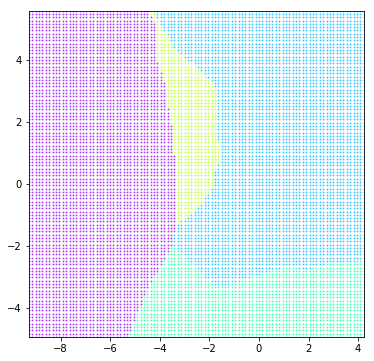

Train step  50 :  0.8478
limit error:  [0. 0. 0. 0.]


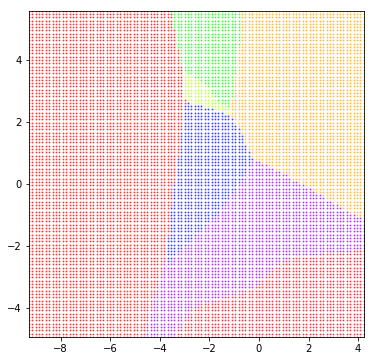

Train step  100 :  0.873
limit error:  [0. 0. 0. 0.]


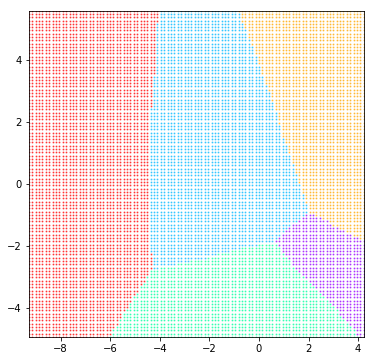

Train step  150 :  0.882
limit error:  [0. 0. 0. 0.]


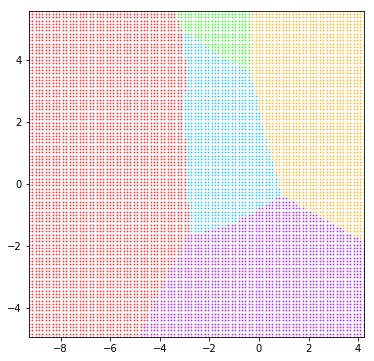

Train step  200 :  0.9068
limit error:  [0. 0. 0. 0.]


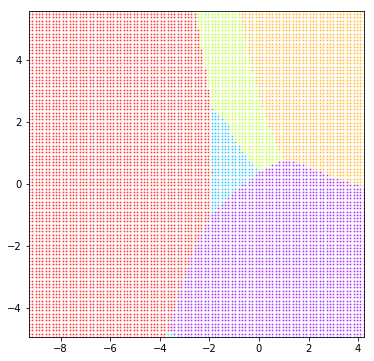

Train step  250 :  0.9098
limit error:  [0. 0. 0. 0.]


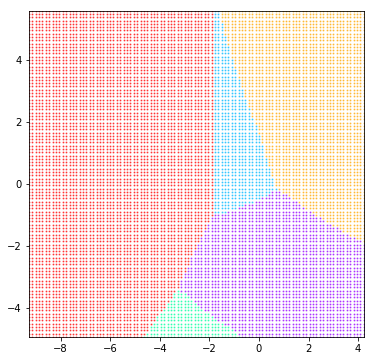

Train step  300 :  0.93
limit error:  [0. 0. 0. 0.]


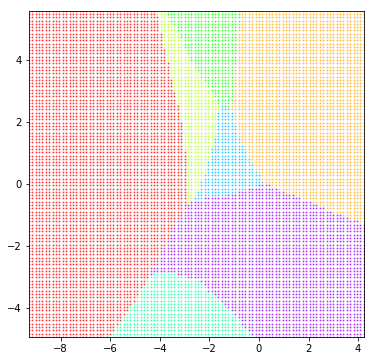

Train step  350 :  0.9196
limit error:  [0. 0. 0. 0.]


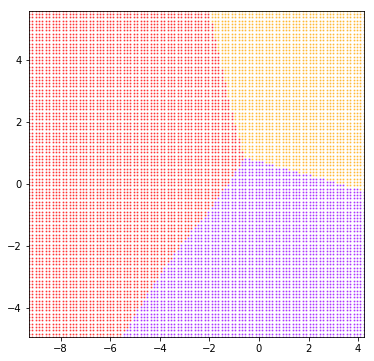

Train step  400 :  0.925
limit error:  [0. 0. 0. 0.]


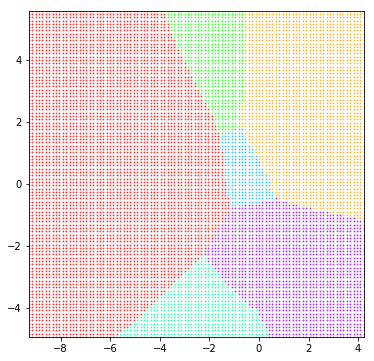

Train step  450 :  0.9294
limit error:  [0. 0. 0. 0.]


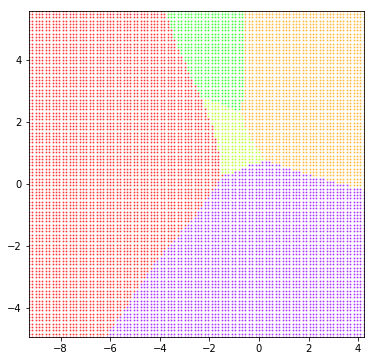

Train step  500 :  0.9282
limit error:  [0. 0. 0. 0.]


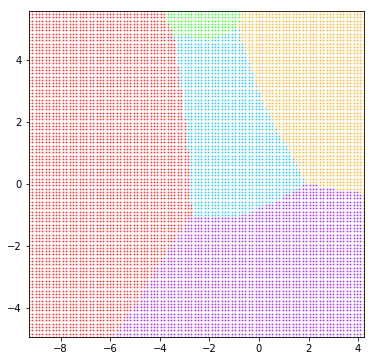

Train step  550 :  0.9308
limit error:  [0. 0. 0. 0.]


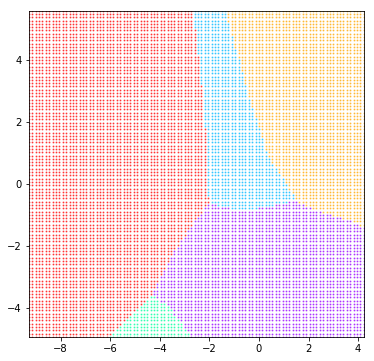

Train step  600 :  0.94
limit error:  [0. 0. 0. 0.]


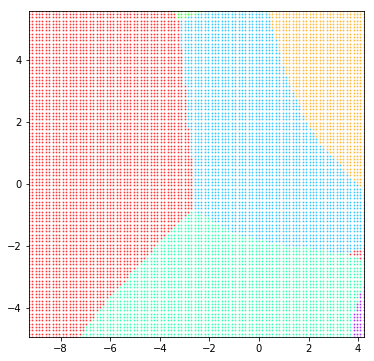

Train step  650 :  0.945
limit error:  [0. 0. 0. 0.]


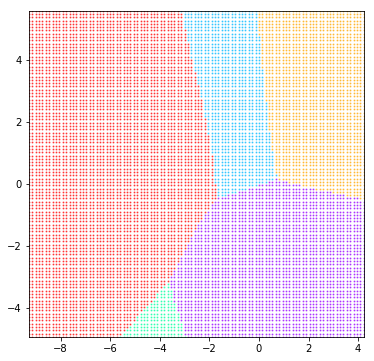

Train step  700 :  0.9472
limit error:  [0. 0. 0. 0.]


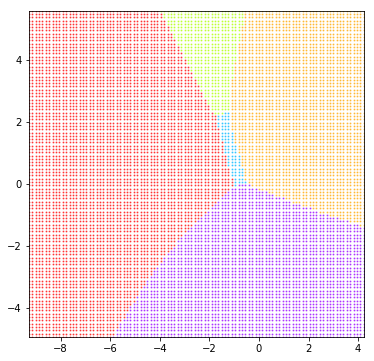

Train step  750 :  0.9488
limit error:  [0. 0. 0. 0.]


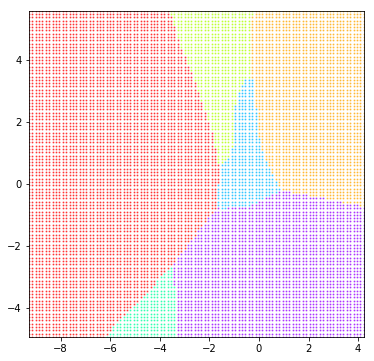

Train step  800 :  0.9518
limit error:  [0. 0. 0. 0.]


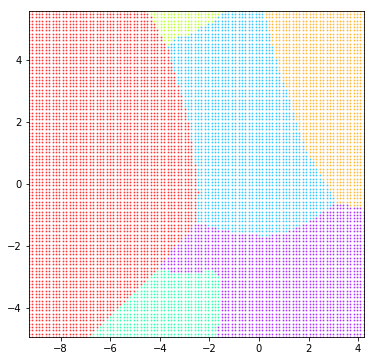

Train step  850 :  0.9492
limit error:  [0. 0. 0. 0.]


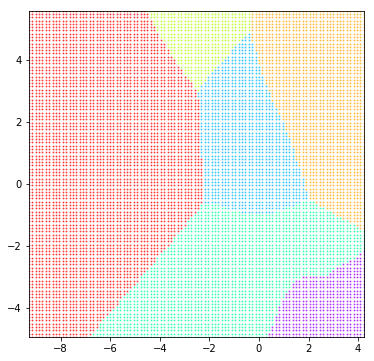

Train step  900 :  0.9486
limit error:  [0. 0. 0. 0.]


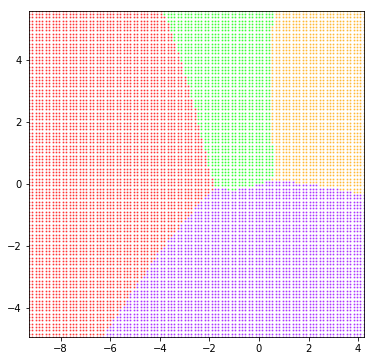

Train step  950 :  0.956
limit error:  [0. 0. 0. 0.]


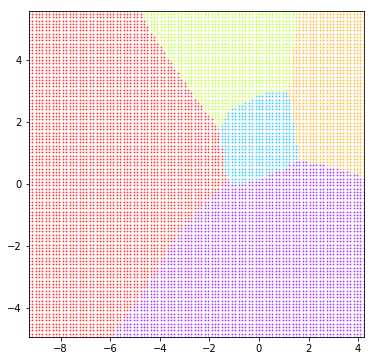

INFO:tensorflow:Restoring parameters from .temp/76294/model.ckpt
Training finished with validation accuracy: 0.956


[0.1464,
 0.8478,
 0.873,
 0.882,
 0.9068,
 0.9098,
 0.93,
 0.9196,
 0.925,
 0.9294,
 0.9282,
 0.9308,
 0.94,
 0.945,
 0.9472,
 0.9488,
 0.9518,
 0.9492,
 0.9486,
 0.956]

In [20]:
def track_training(nn):
    def doit(*args, **kwargs):
        show_decision_grid3([0,1], nn)
    return doit
fcn1.fit(data, lambda i, val_acc: i<1000, perform_action=track_training(fcn1))
    

Train step  0 :  0.0898
limit error:  [0. 0. 0. 0.]


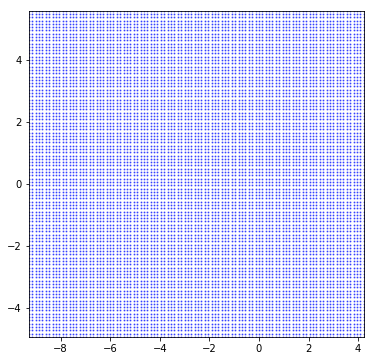

Train step  50 :  0.8454
limit error:  [0. 0. 0. 0.]


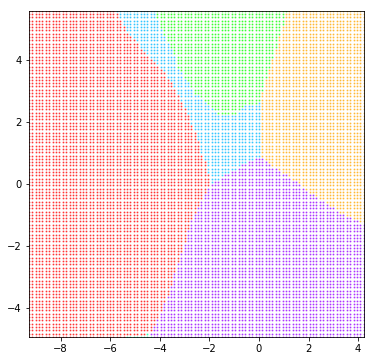

Train step  100 :  0.8684
limit error:  [0. 0. 0. 0.]


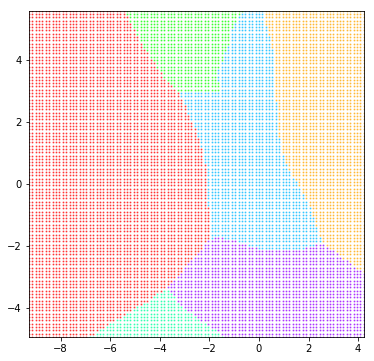

Train step  150 :  0.9092
limit error:  [0. 0. 0. 0.]


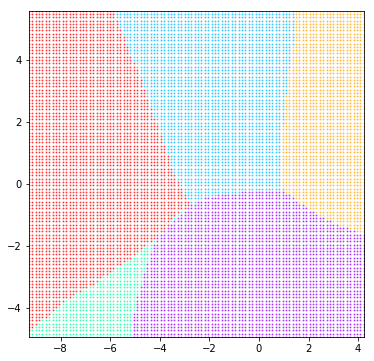

Train step  200 :  0.9086
limit error:  [0. 0. 0. 0.]


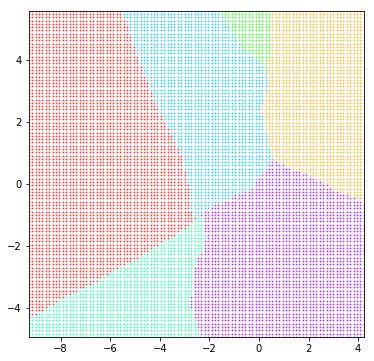

Train step  250 :  0.9278
limit error:  [0. 0. 0. 0.]


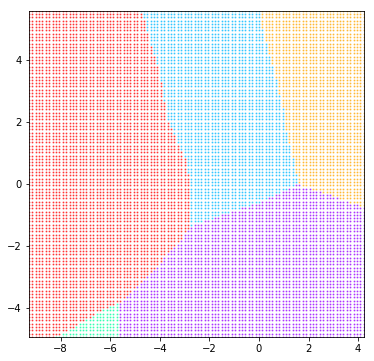

Train step  300 :  0.9228
limit error:  [0. 0. 0. 0.]


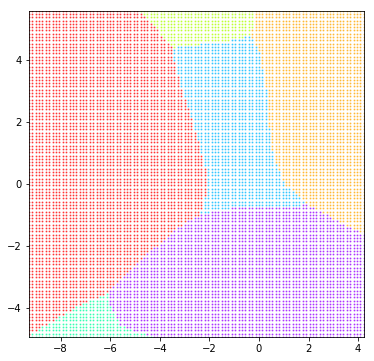

Train step  350 :  0.9262
limit error:  [0. 0. 0. 0.]


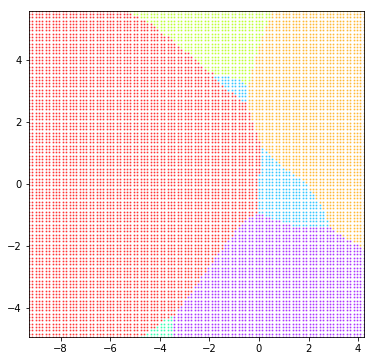

Train step  400 :  0.9376
limit error:  [0. 0. 0. 0.]


KeyboardInterrupt: 

In [21]:
#fcn2.set_session(sess)
#fcn2.fit(data, lambda i, val_acc: i<1000, perform_action=track_training(fcn2))

In [ ]:
data.X.shape

# Visualize Overfitting
Lets see, if we can explain overfitting using this method. We shuffle the labels, and use as train and validation set a small and identical subset of our data.
1. Shuffle labels
2. Get new network
3. Do experiment from above

# Adversarial Examples
We know, that whereever we are, we are close to the border of any other class - we know it because of adversarial examples. In the PC dimensions, the decision volumes look pretty compact and only a small portion of samples is close to the borders. Let´s choose a random real digit, generate the adversarial examples and show the decision borders in a hyperplane that contains the change (x_originak-x_adversarial).

We can try to answer this question:
Are we always close, because there are hyperplanes in which the decision borders are not compact (many points are close too a border)
or
Is every point always close to some border, because in every hyperplane a small fraction of points is close to a border, but as we have so many of them, the fractions add up to the whole space?

# Visualize Gradient during training
For a two class problem, 